In [85]:
import pandas as pd
import numpy as np
matches = pd.read_csv("cleaned_champions_league_match_stats.csv")

In [86]:
# Filtering the dataset to only have past matches
matches_past = matches[matches['is_future_game'] == 0].sort_values("Date").reset_index(drop=True)
matches_future = matches[matches['is_future_game'] == 1].sort_values("Date").reset_index(drop=True)


### Development of ELO

This will be the baseline rating for each team, that will dynamcially update after each match. The initial ratings will begin from a league rating. This league rating will be determined from the folliwng website http://clubelo.com/, and is using the ELO rating as of Sept 13, 2025

In [95]:
# Development of an initial ELO rating for each team

league_base_elo = {
    "Premier League": 1775,
    "La Liga": 1700,
    "Bundesliga": 1680,
    "Serie A": 1700,
    "Ligue 1": 1670,
    "Eredivisie": 1504,
    "Primeira Liga": 1500,
    "Pro League A": 1500,
    "Super Lig": 1425,
    "Danish Superliga": 1470,
}

# Setting lower base elos for non-champions league teams, as usually these are teams who are worse in their respective leagues than champions league teams
league_base_elo_non_cl = {
    "Premier League": 1625,
    "La Liga": 1550,
    "Bundesliga": 1530,
    "Serie A": 1550,
    "Ligue 1": 1520,
    "Eredivisie": 1350,
    "Primeira Liga": 1350,
    "Pro League A": 1350,
    "Super Lig": 1275,
    "Danish Superliga": 1320,
}



default_lower_league_elo = 1350

default_lower_league_elo_non_cl = 1200

# Determine each team’s league (filter only league matches)
leagues = list(league_base_elo.keys())
df_league = matches_past[matches_past["Comp"].isin(leagues)]
team_league = df_league.groupby("Team")["Comp"].first().to_dict()
opponent_league = df_league.groupby("Opponent")["Comp"].first().to_dict()

# Initialize Elo dictionary
elo = {}
for team in matches_past['Team'].unique():
    if team in team_league:
        elo[team] = league_base_elo[team_league[team]]
    else:
        elo[team] = default_lower_league_elo
for team in matches_past['Opponent'].unique():
    if team not in matches_past['Team'].unique():
        if team in opponent_league:
            elo[team] = league_base_elo_non_cl[opponent_league[team]]
        else:
            elo[team] = default_lower_league_elo_non_cl


elo

{'Qairat Almaty': 1350,
 'Qarabag': 1350,
 'FC Copenhagen': 1470,
 'Slavia Prague': 1350,
 'Galatasaray': 1350,
 'Club Brugge': 1500,
 'Union SG': 1500,
 'PSV Eindhoven': 1504,
 'Marseille': 1670,
 'Olympiacos': 1350,
 'Arsenal': 1775,
 'Athletic Club': 1700,
 'Ajax': 1504,
 'Newcastle United': 1775,
 'Sporting CP': 1500,
 'Villarreal': 1700,
 'Tottenham Hotspur': 1775,
 'Monaco': 1670,
 'Barcelona': 1700,
 'Liverpool': 1775,
 'Napoli': 1700,
 'Bayer Leverkusen': 1680,
 'Eintracht Frankfurt': 1680,
 'Atalanta': 1700,
 'Pafos FC': 1350,
 'BodoGlimt': 1350,
 'Benfica': 1500,
 'Paris Saint Germain': 1670,
 'Internazionale': 1700,
 'Real Madrid': 1700,
 'Manchester City': 1775,
 'Chelsea': 1775,
 'Juventus': 1700,
 'Atletico Madrid': 1700,
 'Dortmund': 1680,
 'Bayern Munich': 1680,
 'Maccabi Haifa': 1200,
 'Red Star': 1200,
 'Alashkert': 1200,
 'Fola Esch': 1200,
 'AC Omonia': 1200,
 'Basel': 1200,
 'Kisvárda': 1200,
 'Red Imps': 1200,
 'Lyngby': 1320,
 'Hradec Králové': 1200,
 'Breiðablik

### Creating Expected Score 

The Expected score formula is calculating the probability that a team wins, given their elo and their opponents elo. It follows this formula

​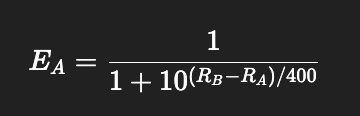

Where

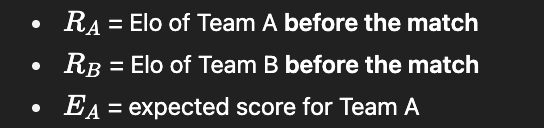

In [96]:
def expected_score(team_elo, opp_elo):
    return 1 / (1 + 10 ** ((opp_elo - team_elo) / 400))

In [97]:
# This is weighting, which adjusts how much you gain or lose after each match, based on the competition

# This will be the initial factor change. THIS MAY NEED TO BE TUNED
K_base = 20.0

competition_weights = {
    "Champions Lg": 1.3,
    "Europa Lg": 1.1,
    "Conf Lg": 1.0
}

stage_weights = {
    "League Phase": 1.0,
    "Round of 16": 1.2,
    "Quarter-finals": 1.4,
    "Semi-finals": 1.75,
    "Final": 2.0
}

In [98]:
# Mapping the weights to the matches
def get_competition_weight(comp):
    return competition_weights.get(comp, 1.0)

def get_stage_weight(stage):
    return stage_weights.get(stage, 1.0)


### Implemention the Elo Update Formula

This code loops through the past matches, and updates the elo based on the formula

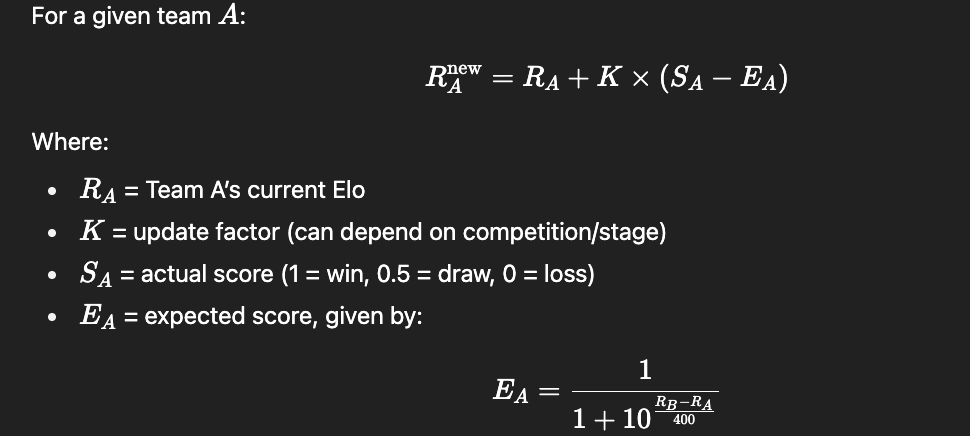

In [99]:
matches_past["Result_num"] = matches_past["Result"].map({"W": 1, "D": 0.5, "L": 0})

In [100]:
# Setting up list placeholders to store elo ratings before and after each match
team_elo_before = []
opp_elo_before = []
# Loops thorugh every row in the past matches dataframe
for idx, row in matches_past.iterrows():
    # Determining key attributes about the game
    team = row["Team"]
    opp = row["Opponent"]
    comp = row.get("Comp", "")
    round = row.get("Round", "")

    # store current elo, making the elo the lower league default if team not found
    team_elo_before.append(elo.get(team, default_lower_league_elo))
    opp_elo_before.append(elo.get(opp, default_lower_league_elo))

    # result as S (Win=1, Draw=0.5, Loss=0)
    S = row["Result_num"]
    if pd.isna(S):
        # skip updates if no result (this is a safeguard, as all games in this dataset should have results)
        continue

    # Calculate expected scores using formula defined earlier
    EA = expected_score(elo[team], elo[opp])
    EB = expected_score(elo[opp], elo[team])

    # Determine K value based on competition and stage
    comp_mult = get_competition_weight(comp)
    stage_mult = get_stage_weight(round)
    K_match = K_base * comp_mult * stage_mult

    # Update Elos
    elo[team] += K_match * (S - EA)
    elo[opp] += K_match * ((1 - S) - EB)

# attach the before-match elos
matches_past["team_elo"] = team_elo_before
matches_past["opp_elo"]  = opp_elo_before
matches_past["elo_diff"] = matches_past["team_elo"] - matches_past["opp_elo"]


In [93]:
elo

{'Qairat Almaty': 1257.0740473092403,
 'Qarabag': 1318.2938720131303,
 'FC Copenhagen': 1459.522018569568,
 'Slavia Prague': 1448.3454479991399,
 'Galatasaray': 1477.9129399176825,
 'Club Brugge': 1572.7736993089384,
 'Union SG': 1566.961042733049,
 'PSV Eindhoven': 1614.0359539516592,
 'Marseille': 1592.8217072901296,
 'Olympiacos': 1471.5284040653744,
 'Arsenal': 1788.0157261343531,
 'Athletic Club': 1643.986473065203,
 'Ajax': 1507.5076024009484,
 'Newcastle United': 1705.4778033388395,
 'Sporting CP': 1586.0626462622197,
 'Villarreal': 1693.841497001646,
 'Tottenham Hotspur': 1650.562578906647,
 'Monaco': 1608.9478859233604,
 'Barcelona': 1766.1347017916307,
 'Liverpool': 1849.1676174843544,
 'Napoli': 1735.6009654732782,
 'Bayer Leverkusen': 1660.4909013425024,
 'Eintracht Frankfurt': 1617.6715728532295,
 'Atalanta': 1658.720579040384,
 'Pafos FC': 1334.8876377912616,
 'BodoGlimt': 1367.6260635652134,
 'Benfica': 1619.7739351063242,
 'Paris Saint Germain': 1910.2830169829685,
 'In

         Date             Opponent Result     team_elo      opp_elo  \
0  2024-08-18              Chelsea      W  1800.698076  1773.042732   
1  2024-08-24         Ipswich Town      W  1818.585577  1619.361484   
2  2024-08-31             West Ham      W  1823.406963  1631.502420   
3  2024-09-14            Brentford      W  1828.384201  1583.866935   
4  2024-09-18       Internazionale      D  1828.989939  1744.714819   
5  2024-09-22              Arsenal      D  1825.897039  1828.243586   
6  2024-09-28     Newcastle United      D  1826.028227  1720.529168   
7  2024-10-01    Slovan Bratislava      W  1820.290880  1200.000000   
8  2024-10-05               Fulham      W  1821.002413  1638.172016   
9  2024-10-20               Wolves      W  1826.177487  1602.177274   
10 2024-10-23        Sparta Prague      W  1830.496409  1238.707312   
11 2024-10-26          Southampton      W  1831.330735  1613.017040   
12 2024-11-02          Bournemouth      L  1835.761535  1615.735001   
13 202

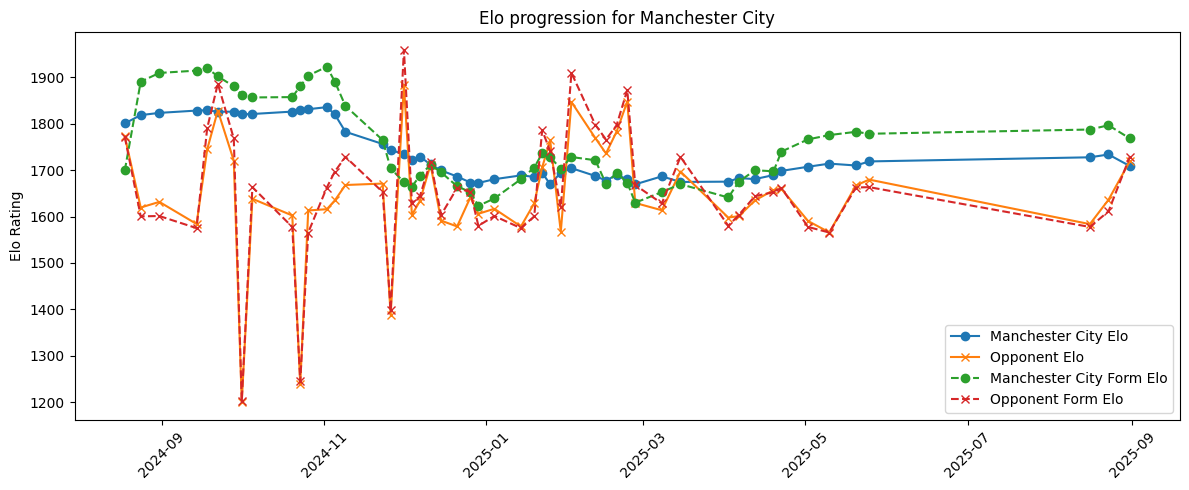

In [107]:
# Function to check Elo progression for a team to verify calculations
def check_team_elo_progression(matches_df, team_name, show_columns=None):
    """
    Prints and plots Elo progression for a team to verify calculations.
    
    Parameters:
    - matches_df: DataFrame with matches and Elo columns
    - team_name: string, name of the team to check
    - show_columns: list of extra columns to display (optional)
    """
    # Filter matches involving the team
    team_matches = matches_df[matches_df["Team"] == team_name].copy()
    team_matches = team_matches.sort_values("Date").reset_index(drop=True)
    
    # Columns to show by default
    columns_to_show = ["Date", "Opponent", "Result", "team_elo", "opp_elo", "form_elo", "opp_form_elo", "elo_diff", "form_elo_diff"]
    if show_columns:
        columns_to_show += show_columns
    
    # Print the table
    print(team_matches[columns_to_show])
    
    # Optional: plot progression
    try:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(12,5))
        plt.plot(team_matches["Date"], team_matches["team_elo"], marker='o', label=f"{team_name} Elo")
        plt.plot(team_matches["Date"], team_matches["opp_elo"], marker='x', label="Opponent Elo")
        plt.plot(team_matches["Date"], team_matches["form_elo"], marker='o', linestyle='--', label=f"{team_name} Form Elo")
        plt.plot(team_matches["Date"], team_matches["opp_form_elo"], marker='x', linestyle='--', label="Opponent Form Elo")
        plt.xticks(rotation=45)
        plt.ylabel("Elo Rating")
        plt.title(f"Elo progression for {team_name}")
        plt.legend()
        plt.tight_layout()
        plt.show()
    except ImportError:
        print("Matplotlib not installed; skipping plot.")

# Example usage
check_team_elo_progression(matches_past, "Manchester City")


In [ ]:
# Final Elo after processing all past matches
final_elo = pd.Series(elo).sort_values(ascending=False)
print(final_elo.head(50))


Paris Saint Germain    1910.283017
Liverpool              1849.167617
Arsenal                1788.015726
Internazionale         1776.497202
Bayern Munich          1775.127896
Chelsea                1771.703287
Barcelona              1766.134702
Real Madrid            1760.338694
Napoli                 1735.600965
Brighton               1728.597175
Dortmund               1713.873408
Atletico Madrid        1711.122595
Newcastle United       1705.477803
Manchester City        1699.202390
Villarreal             1693.841497
Juventus               1685.807336
Fulham                 1663.282766
Bournemouth            1662.518867
Aston Villa            1661.536912
Bayer Leverkusen       1660.490901
Atalanta               1658.720579
Everton                1652.550270
Tottenham Hotspur      1650.562579
Athletic Club          1643.986473
Crystal Palace         1643.758203
Nott'ham Forest        1628.251072
Leeds United           1622.154302
Benfica                1619.773935
Atlético Madrid     

In [ ]:
# Get unique teams in your dataset
teams = matches_past["Team"].unique()

# Filter Elo dictionary to only these teams
team_elo_only = {team: elo_val for team, elo_val in elo.items() if team in teams}

# Convert to Series and sort
team_elo_series = pd.Series(team_elo_only).sort_values(ascending=False)

print(team_elo_series.head(50))

Paris Saint Germain    1910.283017
Liverpool              1849.167617
Arsenal                1788.015726
Internazionale         1776.497202
Bayern Munich          1775.127896
Chelsea                1771.703287
Barcelona              1766.134702
Real Madrid            1760.338694
Napoli                 1735.600965
Dortmund               1713.873408
Atletico Madrid        1711.122595
Newcastle United       1705.477803
Manchester City        1699.202390
Villarreal             1693.841497
Juventus               1685.807336
Bayer Leverkusen       1660.490901
Atalanta               1658.720579
Tottenham Hotspur      1650.562579
Athletic Club          1643.986473
Benfica                1619.773935
Eintracht Frankfurt    1617.671573
PSV Eindhoven          1614.035954
Monaco                 1608.947886
Marseille              1592.821707
Sporting CP            1586.062646
Club Brugge            1572.773699
Union SG               1566.961043
Ajax                   1507.507602
Galatasaray         

### Applying a Form Elo

This will take into account recent team form, so that elo can be boosted based on how the team has played in their recent matches

** Sections of the below code were written by GitHub Copilot **

In [101]:
# Sorting date and time
matches_past["Date"] = pd.to_datetime(matches_past["Date"])
matches_past = matches_past.sort_values(["Team", "Date"]).copy()

# Days since last match for team and opponent
matches_past["days_since_last"] = matches_past.groupby("Team")["Date"].diff().dt.days.fillna(0)
matches_past["days_since_last_opp"] = matches_past.groupby("Opponent")["Date"].diff().dt.days.fillna(0)

# Determine baseline Elo
matches_past["team_elo_base"] = matches_past["Comp"].map(lambda x: league_base_elo.get(x, default_lower_league_elo))
matches_past["opp_elo_base"] = matches_past["Comp"].map(lambda x: league_base_elo.get(x, default_lower_league_elo_non_cl))

# Use previous Elo for decay; first match uses baseline
matches_past["prev_team_elo"] = matches_past.groupby("Team")["team_elo"].shift(1).fillna(matches_past["team_elo_base"])
matches_past["prev_opp_elo"] = matches_past.groupby("Opponent")["opp_elo"].shift(1).fillna(matches_past["opp_elo_base"])


In [102]:
# SIMPLE FORM-ADJUSTED ELO SYSTEM - FIXED VERSION
def calculate_form_elo(team_matches, current_date):
    """
    Simple ELO adjustment based on recent form (last 5 games)
    
    How it works:
    1. Look at last 5 games BEFORE current match
    2. Calculate win percentage (W=1, D=0.5, L=0)
    3. Apply small adjustment: +5% ELO for perfect form, -5% for terrible form
    
    Example: Team with 1800 ELO on 5-game winning streak gets ~1890 ELO
    """
    if len(team_matches) == 0:
        return 1500
    
    # Get base ELO (standard ELO rating BEFORE current match)
    if len(team_matches) > 0:
        base_elo = team_matches['team_elo'].iloc[-1]
    else:
        return 1500
    
    # Get last 5 games BEFORE current match for form assessment
    if len(team_matches) >= 5:
        last_5_games = team_matches['Result'].tail(5)
    else:
        last_5_games = team_matches['Result']  # Use all available games if less than 5
    
    if len(last_5_games) == 0:
        return base_elo
    
    # Calculate form score (0.0 = all losses, 1.0 = all wins)
    form_score = last_5_games.map({'W': 1.0, 'D': 0.5, 'L': 0.0}).mean()
    
    # Simple form adjustment: ±5% maximum
    # form_score 1.0 (perfect) = +5%, 0.5 (average) = 0%, 0.0 (terrible) = -5%
    form_adjustment_percent = (form_score - 0.5) * 0.1  # 0.1 = 10% range total
    
    # Apply the adjustment to base ELO
    form_elo = base_elo * (1 + form_adjustment_percent)
    
    return form_elo

print("Created FIXED form-adjusted ELO system!")
print("- Uses last 5 games BEFORE current match")
print("- Max ±5% adjustment for form")
print("- Win streaks = higher ELO, loss streaks = lower ELO")

Created FIXED form-adjusted ELO system!
- Uses last 5 games BEFORE current match
- Max ±5% adjustment for form
- Win streaks = higher ELO, loss streaks = lower ELO


In [103]:
# Apply the SIMPLE form-adjusted ELO system
print("Calculating simple form-adjusted ELO for all matches...")

# Initialize new columns - just one form-adjusted ELO
matches_past["form_elo"] = 0.0
matches_past["opp_form_elo"] = 0.0

# Process each match to calculate form-adjusted ELO
for idx, row in matches_past.iterrows():
    if idx % 500 == 0:  # Progress indicator
        print(f"Processing match {idx}/{len(matches_past)}")
    
    current_date = row['Date']
    team = row['Team']
    opponent = row['Opponent']
    
    # Get all previous matches for the team (before current date)
    team_history = matches_past[(matches_past['Team'] == team) & 
                               (matches_past['Date'] < current_date)].copy()
    
    opp_history = matches_past[(matches_past['Team'] == opponent) & 
                              (matches_past['Date'] < current_date)].copy()
    
    # Calculate form-adjusted ELO for team
    if len(team_history) > 0:
        team_form_elo = calculate_form_elo(team_history, current_date)
    else:
        # Use initial ELO if no history
        team_form_elo = elo.get(team, 1500)
    
    # Calculate form-adjusted ELO for opponent
    if len(opp_history) > 0:
        opp_form_elo = calculate_form_elo(opp_history, current_date)
    else:
        opp_form_elo = elo.get(opponent, 1500)
    
    # Store the values
    matches_past.at[idx, "form_elo"] = team_form_elo
    matches_past.at[idx, "opp_form_elo"] = opp_form_elo

# Calculate ELO difference
matches_past["form_elo_diff"] = matches_past["form_elo"] - matches_past["opp_form_elo"]

print("Simple form-adjusted ELO calculation complete!")
print(f"Sample of new form ELO features:")
print(matches_past[['Team', 'Date', 'Result', 'team_elo', 'form_elo']].tail(10))

Calculating simple form-adjusted ELO for all matches...
Processing match 500/2790
Processing match 1500/2790
Processing match 500/2790
Processing match 1500/2790
Processing match 2000/2790
Processing match 2500/2790
Processing match 2000/2790
Processing match 2500/2790
Processing match 1000/2790
Processing match 1000/2790
Processing match 0/2790
Processing match 0/2790
Simple form-adjusted ELO calculation complete!
Sample of new form ELO features:
            Team       Date Result     team_elo     form_elo
2461  Villarreal 2025-04-23      L  1638.970897  1657.252770
2484  Villarreal 2025-04-27      W  1625.975848  1655.360606
2508  Villarreal 2025-05-03      W  1634.025287  1642.235607
2546  Villarreal 2025-05-10      W  1641.224149  1666.705792
2572  Villarreal 2025-05-14      W  1648.331887  1674.048632
2601  Villarreal 2025-05-18      W  1655.634680  1697.781843
2620  Villarreal 2025-05-25      W  1681.653053  1738.416414
2693  Villarreal 2025-08-15      W  1686.298738  1765.735706

In [104]:
# Populate future matches with our SIMPLE form-adjusted ELO system
print("Populating future matches with form-adjusted ELO...")

# Standard ELO for future matches
matches_future["team_elo"] = matches_future["Team"].map(elo)
matches_future["opp_elo"] = matches_future["Opponent"].map(elo)
matches_future["elo_diff"] = matches_future["team_elo"] - matches_future["opp_elo"]

# Add prev_team_elo and prev_opp_elo for consistency with training data
matches_future["prev_team_elo"] = matches_future["team_elo"]  # For future matches, current ELO = prev ELO
matches_future["prev_opp_elo"] = matches_future["opp_elo"]

# Calculate form-adjusted ELO for future matches
matches_future["form_elo"] = 0.0
matches_future["opp_form_elo"] = 0.0

for idx, row in matches_future.iterrows():
    team = row['Team']
    opponent = row['Opponent']
    
    # Get each team's full match history (all past matches)
    team_history = matches_past[matches_past['Team'] == team].copy()
    opp_history = matches_past[matches_past['Team'] == opponent].copy()
    
    # Calculate current form-adjusted ELO based on their recent form
    if len(team_history) > 0:
        team_form_elo = calculate_form_elo(team_history, row['Date'])
    else:
        team_form_elo = elo.get(team, 1500)
    
    if len(opp_history) > 0:
        opp_form_elo = calculate_form_elo(opp_history, row['Date'])
    else:
        opp_form_elo = elo.get(opponent, 1500)
    
    # Store the form-adjusted ELO - using consistent column names
    matches_future.at[idx, "form_elo"] = team_form_elo
    matches_future.at[idx, "opp_form_elo"] = opp_form_elo

# Calculate form-adjusted ELO difference
matches_future["form_elo_diff"] = matches_future["form_elo"] - matches_future["opp_form_elo"]

print("Future matches populated with simple form-adjusted ELO!")
print(f"Features available: Standard ELO + Form-Adjusted ELO")
print(matches_future[['Team', 'Opponent', 'team_elo', 'form_elo', 'form_elo_diff']].head())



Populating future matches with form-adjusted ELO...
Future matches populated with simple form-adjusted ELO!
Features available: Standard ELO + Form-Adjusted ELO
                  Team             Opponent     team_elo     form_elo  \
0            Marseille              Lorient  1592.821707  1620.800509   
1            BodoGlimt         Kristiansund  1367.626064  1389.366699   
2  Eintracht Frankfurt     Bayer Leverkusen  1617.671573  1659.241816   
3     Bayer Leverkusen  Eintracht Frankfurt  1660.490901  1630.569933   
4              Benfica          Santa Clara  1619.773935  1680.870206   

   form_elo_diff  
0     108.519927  
1     185.468501  
2      28.671883  
3     -28.671883  
4     328.219089  
Future matches populated with simple form-adjusted ELO!
Features available: Standard ELO + Form-Adjusted ELO
                  Team             Opponent     team_elo     form_elo  \
0            Marseille              Lorient  1592.821707  1620.800509   
1            BodoGlimt         

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

=== FORM ELO PROGRESSION FOR Newcastle United ===
         Date        Opponent Result     team_elo     form_elo
70 2025-02-26       Liverpool      L  1714.325142  1696.177509
71 2025-03-10        West Ham      W  1708.403737  1697.181891
72 2025-04-02       Brentford      W  1715.866910  1691.319700
73 2025-04-07  Leicester City      W  1721.879552  1733.025579
74 2025-04-13  Manchester Utd      W  1728.253176  1773.535938
75 2025-04-16  Crystal Palace      W  1734.801807  1780.100771
76 2025-04-19     Aston Villa      L  1741.767004  1821.541898
77 2025-04-26    Ipswich Town      W  1729.098762  1794.020014
78 2025-05-04        Brighton      D  1735.719219  1780.971725
79 2025-05-11         Chelsea      W  1745.232992  1770.433603
80 2025-05-18         Arsenal      L  1745.769933  1780.137652
81 2025-05-25         Everton      L  1736.817657  1745.769933
82 2025-08-16     Aston Villa      D  1724.096422  1736.817657
83 2025-08-25       Liverpool      L  1714.920831  1706.855458
84 20

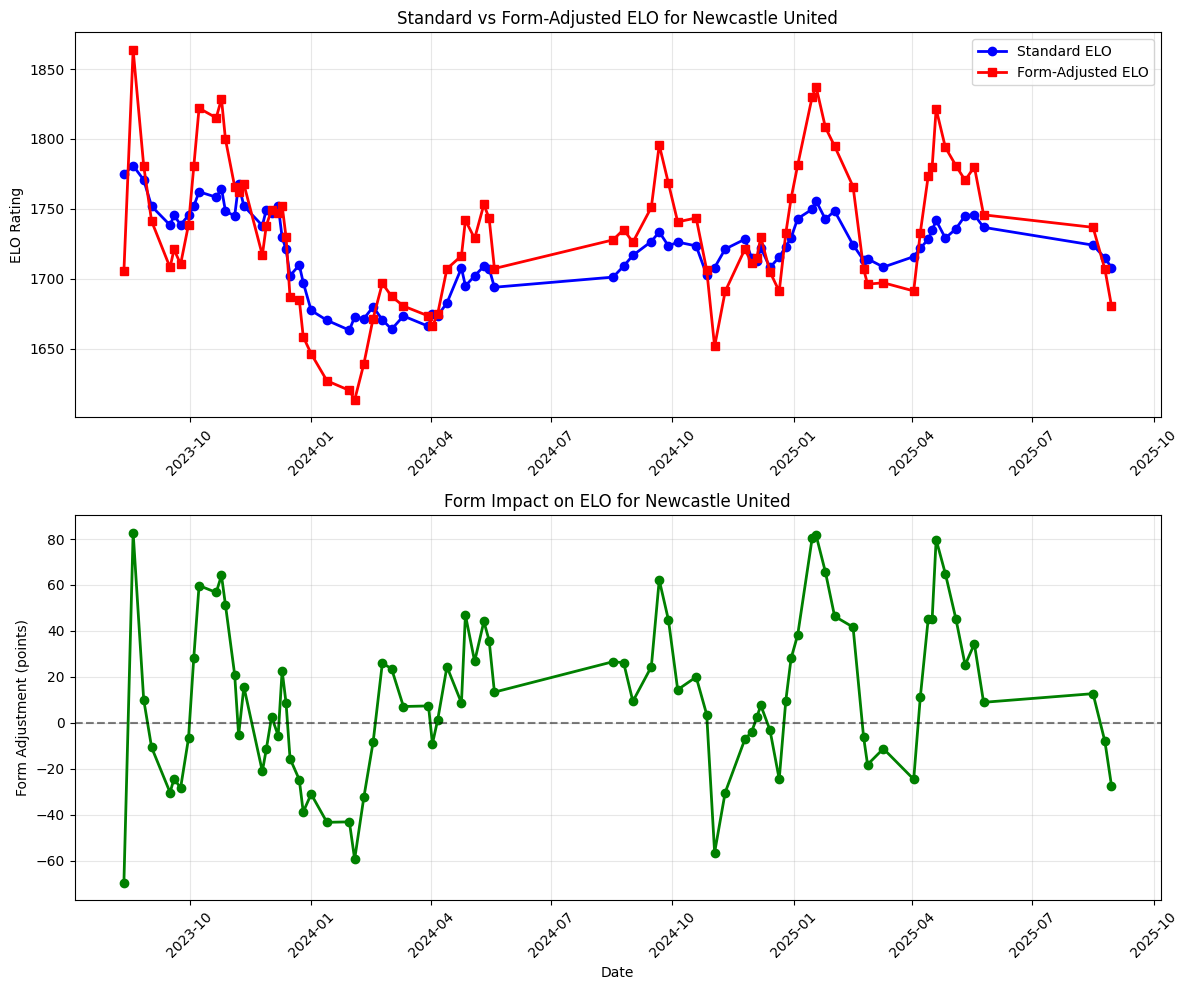


=== FORM ELO STATISTICS FOR Newcastle United ===
Current Standard ELO: 1708.0
Current Form-Adjusted ELO: 1680.6
Form Impact: -27.3 points
Recent form (last 5 games): L L D L D


In [ ]:
# Simple visualization showing form-adjusted ELO
def check_team_form_progression(matches_df, team_name):
    """
    Simple comparison of standard ELO vs form-adjusted ELO
    """
    # Filter matches involving the team
    team_matches = matches_df[matches_df["Team"] == team_name].copy()
    team_matches = team_matches.sort_values("Date").reset_index(drop=True)
    
    # Show the table
    print(f"=== FORM ELO PROGRESSION FOR {team_name} ===")
    print(team_matches[["Date", "Opponent", "Result", "team_elo", "form_elo"]].tail(15))
    
    # Simple plot
    try:
        import matplotlib.pyplot as plt
        
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
        
        # Plot 1: ELO comparison
        ax1.plot(team_matches["Date"], team_matches["team_elo"], 
                marker='o', linewidth=2, label="Standard ELO", color='blue')
        ax1.plot(team_matches["Date"], team_matches["form_elo"], 
                marker='s', linewidth=2, label="Form-Adjusted ELO", color='red')
        
        ax1.set_ylabel("ELO Rating")
        ax1.set_title(f"Standard vs Form-Adjusted ELO for {team_name}")
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        ax1.tick_params(axis='x', rotation=45)
        
        # Plot 2: Form adjustment impact
        form_impact = team_matches["form_elo"] - team_matches["team_elo"]
        ax2.plot(team_matches["Date"], form_impact, 
                marker='o', linewidth=2, color='green')
        ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
        ax2.set_ylabel("Form Adjustment (points)")
        ax2.set_xlabel("Date")
        ax2.set_title(f"Form Impact on ELO for {team_name}")
        ax2.grid(True, alpha=0.3)
        ax2.tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()
        
        # Print simple statistics
        print(f"\n=== FORM ELO STATISTICS FOR {team_name} ===")
        recent_data = team_matches.tail(1).iloc[0]
        print(f"Current Standard ELO: {recent_data['team_elo']:.1f}")
        print(f"Current Form-Adjusted ELO: {recent_data['form_elo']:.1f}")
        print(f"Form Impact: {recent_data['form_elo'] - recent_data['team_elo']:+.1f} points")
        
        # Show recent form
        recent_results = team_matches['Result'].tail(5).values
        print(f"Recent form (last 5 games): {' '.join(recent_results)}")
        
    except ImportError:
        print("Matplotlib not installed; skipping plot.")

# Test with Liverpool
check_team_form_progression(matches_past, "Newcastle United")

In [105]:
# Compare Standard ELO vs Form-Adjusted ELO
print("=== ELO SYSTEM COMPARISON ===")

# Calculate correlations between different ELO systems and match results
from scipy.stats import pearsonr

# For wins (Result_num = 1), check which ELO difference predicts best
win_matches = matches_past[matches_past['Result_num'] == 1].copy()
draw_matches = matches_past[matches_past['Result_num'] == 0.5].copy()
loss_matches = matches_past[matches_past['Result_num'] == 0].copy()

print(f"Analyzing {len(matches_past)} total matches:")
print(f"- Wins: {len(win_matches)}")
print(f"- Draws: {len(draw_matches)}")  
print(f"- Losses: {len(loss_matches)}")

# Calculate how well each ELO system predicts outcomes
elo_systems = {
    'Standard ELO': 'elo_diff',
    'Form-Adjusted ELO': 'form_elo_diff'
}

print(f"\n=== PREDICTIVE POWER COMPARISON ===")
for name, diff_col in elo_systems.items():
    if diff_col in matches_past.columns:
        # Correlation with actual results
        corr, p_value = pearsonr(matches_past[diff_col].fillna(0), matches_past['Result_num'])
        
        # Average ELO difference for wins vs losses
        avg_diff_wins = win_matches[diff_col].mean()
        avg_diff_losses = loss_matches[diff_col].mean()
        
        print(f"\n{name}:")
        print(f"  Correlation with results: {corr:.3f} (p={p_value:.3f})")
        print(f"  Avg difference for wins: {avg_diff_wins:.1f}")
        print(f"  Avg difference for losses: {avg_diff_losses:.1f}")
        print(f"  Separation (wins-losses): {avg_diff_wins - avg_diff_losses:.1f}")

# Show teams with biggest differences between standard and form-adjusted ELO
print(f"\n=== TEAMS WITH BIGGEST RECENT FORM IMPACT ===")
latest_match_per_team = matches_past.groupby('Team').last()
latest_match_per_team['form_impact'] = (latest_match_per_team['form_elo'] - 
                                       latest_match_per_team['team_elo'])

print("Teams benefiting most from recent form (positive = better recent form):")
top_form = latest_match_per_team.nlargest(10, 'form_impact')[['form_elo', 'team_elo', 'form_impact']]
print(top_form)

print("\nTeams hurt most by recent form (negative = worse recent form):")
bottom_form = latest_match_per_team.nsmallest(10, 'form_impact')[['form_elo', 'team_elo', 'form_impact']]
print(bottom_form)

# Save updated datasets with our simple form-adjusted ELO
matches_past.to_csv("matches_past_elo.csv", index=False)
matches_future.to_csv("matches_future_elo.csv", index=False)


=== ELO SYSTEM COMPARISON ===
Analyzing 2790 total matches:
- Wins: 1632
- Draws: 577
- Losses: 581

=== PREDICTIVE POWER COMPARISON ===

Standard ELO:
  Correlation with results: 0.325 (p=0.000)
  Avg difference for wins: 174.4
  Avg difference for losses: 69.2
  Separation (wins-losses): 105.2

Form-Adjusted ELO:
  Correlation with results: 0.355 (p=0.000)
  Avg difference for wins: 207.7
  Avg difference for losses: 74.6
  Separation (wins-losses): 133.1

=== TEAMS WITH BIGGEST RECENT FORM IMPACT ===
Teams benefiting most from recent form (positive = better recent form):
                        form_elo     team_elo  form_impact
Team                                                      
Paris Saint Germain  2001.870310  1908.417366    93.452944
Real Madrid          1839.317182  1756.369666    82.947516
Villarreal           1777.193597  1698.104798    79.088799
PSV Eindhoven        1708.973639  1630.813267    78.160373
Arsenal              1872.739521  1796.765903    75.973618
Club B